<a href="https://colab.research.google.com/github/SrajanJain1/Tweet-Emotion-Recognition/blob/main/Tweet_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install nlp

     |████████████████████████████████| 1.7MB 9.6MB/s 
     |████████████████████████████████| 245kB 53.2MB/s 


<h4>Importing Libraries and creating functions for better visualisation at the end

In [4]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.5.0


<h4>Importing the data

In [5]:
dataset = nlp.load_dataset('emotion')

Using custom data configuration default


Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [6]:
dataset

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [7]:
train = dataset['train']
test = dataset['test']
val = dataset['validation']

In [9]:
def get_tweet(data):
  tweets = [x['text'] for x in data]
  labels = [x['label'] for x in data]
  return tweets, labels

In [10]:
tweets_train, labels_train = get_tweet(train)
tweets_train[0], labels_train[0]

('i didnt feel humiliated', 'sadness')

<h4>Tokenizing the Tweets</h4>
(Converting text to numbers)

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [12]:
tokenizer = Tokenizer(num_words = 10000, oov_token = '<UNK>')
tokenizer.fit_on_texts(tweets_train)

In [13]:
print(tweets_train[2])
print(tokenizer.texts_to_sequences([tweets_train[2]]))

im grabbing a minute to post i feel greedy wrong
[[17, 3060, 7, 1149, 5, 286, 2, 3, 495, 438]]


<h4> Padding and Truncating</h4>
As all tweets will be of different lengths, some padding and truncating is required.

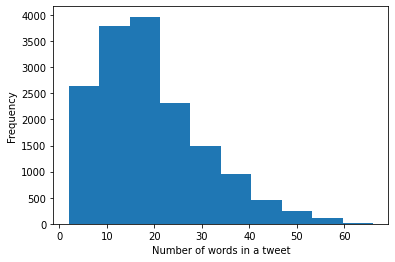

In [15]:
lengths = [len(t.split(' ')) for t in tweets_train]
plt.hist(lengths)
plt.xlabel('Number of words in a tweet')
plt.ylabel('Frequency')
plt.show()

In [17]:
#As there are few tweets whose length is greater than 50, we will truncate all such tweets.
#For sequences with len < 50, we will pad them with zeroes.
maxlen = 50
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [18]:
def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded_seq = pad_sequences(sequences, truncating = 'post', padding = 'post', maxlen = maxlen)
  return padded_seq

In [19]:
padded_train_seq = get_sequences(tokenizer, tweets_train)
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

<h4>Preparing the Labels</h4>

In [20]:
classes = set(labels_train)
print(classes)

{'joy', 'anger', 'love', 'fear', 'surprise', 'sadness'}


(array([4666.,    0., 2159.,    0., 1304.,    0.,  572.,    0., 1937.,
           0., 5362.]),
 array([0.        , 0.45454545, 0.90909091, 1.36363636, 1.81818182,
        2.27272727, 2.72727273, 3.18181818, 3.63636364, 4.09090909,
        4.54545455, 5.        ]),
 <a list of 11 Patch objects>)

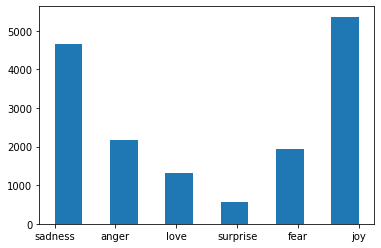

In [23]:
plt.hist(labels_train, bins = 11)

In [24]:
#We have lot of examples for joy and sadness, but not for rest of the classes. So there's a class imbalance problem.
class_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_class = dict((i, j) for j, i in class_to_index.items())
print(class_to_index)

{'joy': 0, 'anger': 1, 'love': 2, 'fear': 3, 'surprise': 4, 'sadness': 5}


In [25]:
name_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])
train_labels = name_to_ids(labels_train)
print(train_labels[0])

5


<h4>Creating, compiling and Training the model</h4>

In [27]:
model = tf.keras.Sequential([
        tf.keras.layers.Embedding(10000, 16, input_length=maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
        tf.keras.layers.Dense(6, activation = 'softmax')                     
])
model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 40)            5920      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40)                9760      
_________________________________________________________________
dense (Dense)                (None, 6)                 246       
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


In [29]:
val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = name_to_ids(val_labels)

In [30]:
h = model.fit(
    padded_train_seq, train_labels, validation_data = (val_seq, val_labels),
    epochs = 20,
    callbacks = [
                 tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
500/500 [==============================] - 18s 16ms/step - loss: 1.3249 - accuracy: 0.4676 - val_loss: 0.8805 - val_accuracy: 0.6690
Epoch 2/20
500/500 [==============================] - 7s 14ms/step - loss: 0.6310 - accuracy: 0.7801 - val_loss: 0.5712 - val_accuracy: 0.8200
Epoch 3/20
500/500 [==============================] - 7s 14ms/step - loss: 0.3644 - accuracy: 0.8849 - val_loss: 0.5215 - val_accuracy: 0.8270
Epoch 4/20
500/500 [==============================] - 7s 14ms/step - loss: 0.2785 - accuracy: 0.9107 - val_loss: 0.4400 - val_accuracy: 0.8615
Epoch 5/20
500/500 [==============================] - 7s 14ms/step - loss: 0.1870 - accuracy: 0.9404 - val_loss: 0.4208 - val_accuracy: 0.8735
Epoch 6/20
500/500 [==============================] - 7s 13ms/step - loss: 0.1530 - accuracy: 0.9502 - val_loss: 0.4717 - val_accuracy: 0.8790
Epoch 7/20
500/500 [==============================] - 7s 13ms/step - loss: 0.1224 - accuracy: 0.9606 - val_loss: 0.4555 - val_accuracy: 0.877

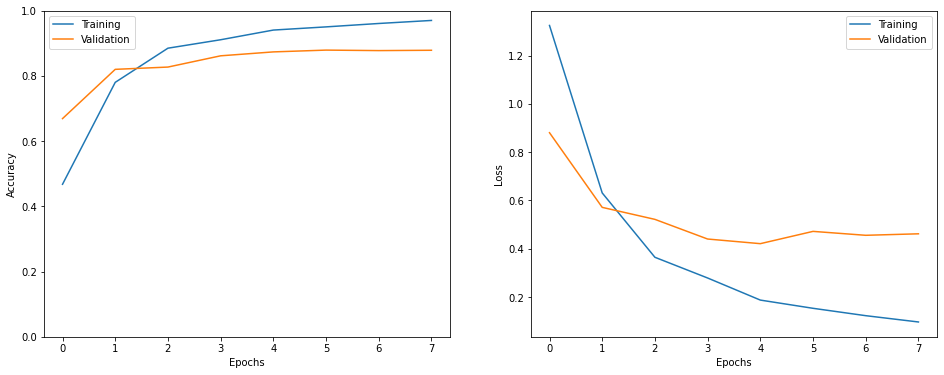

In [31]:
show_history(h)

In [32]:
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = name_to_ids(test_labels)

In [33]:
_ = model.evaluate(test_seq, test_labels)

63/63 [==============================] - 0s 7ms/step - loss: 0.4584 - accuracy: 0.8715


In [34]:
i = random.randint(0, len(test_labels) - 1)

print('Sentence: ', test_tweets[i])
print('Emotion: ', index_to_class[test_labels[i]])

p = model.predict(np.expand_dims(test_seq[i], axis = 0))[0]
predicted_class  = index_to_class[np.argmax(p).astype('uint8')]

print('Predicted Emotion: ',  predicted_class)

Sentence:  im feeling optimistic to finish out these last two weeks strong and probably continue with what i have been doing
Emotion:  joy
Predicted Emotion:  joy


In [35]:
preds = model.predict_classes(test_seq)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


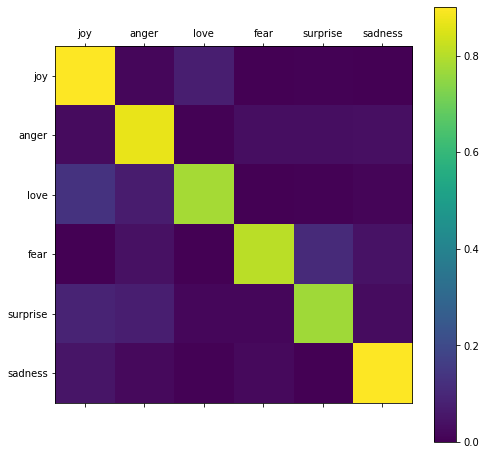

In [36]:
show_confusion_matrix(test_labels, preds, list(classes))